# Lecture 4 - Blob Detection and Connected Components

In this notebook, we will discuss how we will label and measure the properties of objects in our image. Specifically, we will discuss:
1. Blob Detection
1. Connected Components

The contents of this notebook is compiled from the following references:

- C Alis,*"Introduction to Digital Image"*, IIP 2018

Organized by:
Benjur Emmanuel L. Borja

---

## 1. Blob Detection
**Blob Detection**, as the name suggests, allows us to detect objects of interests (blobs) in our image. Blobs are defined as bright objects in a dark background or vice versa. We will be using three methods to automatically detect our blobs:
1. Laplacian of Gaussian (LoG) - takes the laplacian of a gaussian smoothed image
1. Difference of Gaussian (DoG) - takes the difference of two gaussian smoothed image
1. Determinant of Hessian (DoH) - takes maximum in the matrix of the determinant of Hessian

Let's try this out using our image.

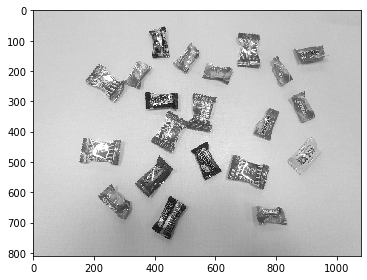

In [2]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
im = rgb2gray(imread('blobs.png'))
imshow(im);

Let's binarize our image first:

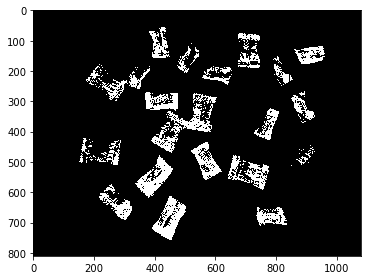

In [3]:
im_bw = im<0.5
imshow(im_bw)

Then let's try LoG:

/opt/conda/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/opt/conda/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/opt/conda/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/opt/conda/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


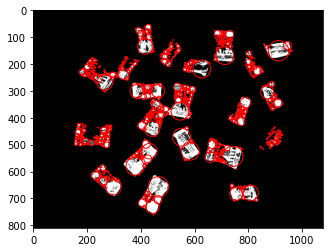

In [4]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

blobs = blob_log(im_bw, max_sigma=30, num_sigma=10, threshold=0.1)

fig, ax = plt.subplots()
ax.imshow(im_bw, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))

What do you observe?

Now let's try using the other two methods:

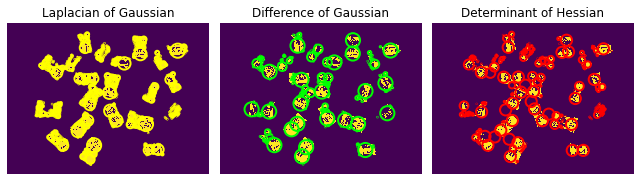

In [5]:
blobs_log = blob_log(im_bw, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(im_bw, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(im_bw, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(im_bw, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

The three methods have multiple advantages and disadvantages. However, most of the time, we will not be looking for circular blobs in our image.

## 2. Connected Components
Instead of automatically looking for circular objects in our image, we can instead look at **Connected Components** as our objects of interest. This allows us to detect objects with irregular shapes and sizes but this heavily relies on properly cleaning our image using morphological operations.

Let's try this again using our image.

In [6]:
from skimage.morphology import erosion, dilation, opening, closing
from skimage.measure import label, regionprops
from skimage.color import label2rgb

def multi_dil(im,num):
    for i in range(num):
        im = dilation(im)
    return im

def multi_ero(im,num):
    for i in range(num):
        im = erosion(im)
    return im

First let's clean our image:

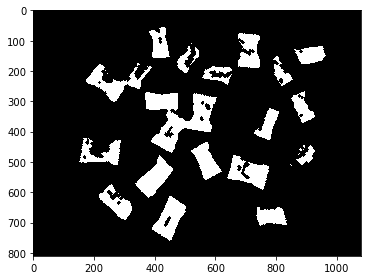

In [7]:
im_cleaned = multi_ero(multi_dil(im_bw,5),5)
imshow(im_cleaned)

Given our cleanes image, we can now use label and regionprops to, well, label and get the region properties of our connected components:

/opt/conda/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


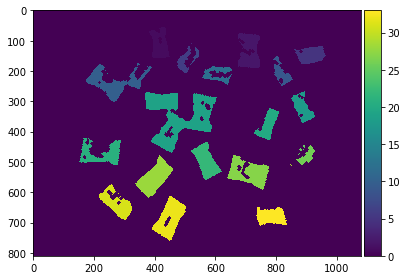

In [8]:
label_im = label(im_cleaned)
imshow(label_im)

What do you see?

Now, let's use regionprops and look at the following properties:
1. area
1. perimeter
1. bbox - bounding box dimensions
1. bbox_area - area of bounding box
1. centroid - coordinate of centroid
1. convex_image - convex hull of the blob 
1. convex_area  - area of the convex hull
1. eccentricity - measure how it fits into an ellipse (0) for circles
1. major_axis_length - length of the major moment of the ellipse fitted
1. minor_axis_length - length of the minor moment of the ellipse fitted

In [9]:
props=regionprops(label_im)
#Example:
props[0].area

4453

## Exercise (Breakout)
The two methods we discussed can now be used to automatically identify and count certain objects of interest in our images. Imagine that we are now Data Scientists for a healthcare facility and we are tasked to create analysis on the following image:
    ![rbc.JPG](rbc.JPG "RBC")
Specifically, we are tasked to:
1. Count the number of cells in the photo.
1. Using regionprops, plot a histogram of the cell sizes.
1. Highlight "irregular" cells that are greater than an area treshold:
    - greater than 1.1x of the mean area of the cells
    - greater than 1.5x of the mean area of the cells
    - greater than 1.Nx of the mean area of the cells (play around with N till you get a satisfactory result)
   *(Hint: exploit your knowledge of the RGB color channels to highlight the cells)

You should be able to answer the following questions:
1. What are the steps you took in segemeting the images into blobs?
1. Obviously, there are normal-sized cells that are connected. What steps did you take to minimize the error due to connected cells?
1. What area threshold worked best in segmenting the "irregular" cells?

For this exercise we use a combination of the label and regionprops/regionprops_table functions from skimage.measure module.  The label function conveniently identifies continuous elements in the image.  Here we assume that continuous elements represent a single cell.  Clearly, this is not entirely true, as some cells overlap.  Another problem that we see from the grayscale image is that the edges have rather low fidelity---not all the cells are captured completely.  To account for this second problem, we apply erosion and dilation to try to improve these areas.  As for the problem with the overlap we use thresholding based on the area quantiles to minimize the impact of these cases.

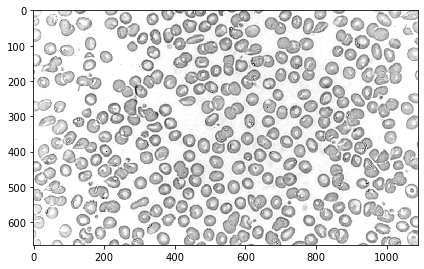

In [10]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
im = rgb2gray(imread('rbc.JPG'))
imshow(im);

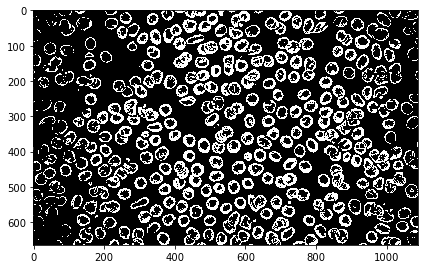

In [13]:
im_bw = im<0.68
imshow(im_bw)

In the next cell we try to address the low fidelity edges, as well as remove some of the final details of a cell (centre).  To do that we use erosion and dilation.

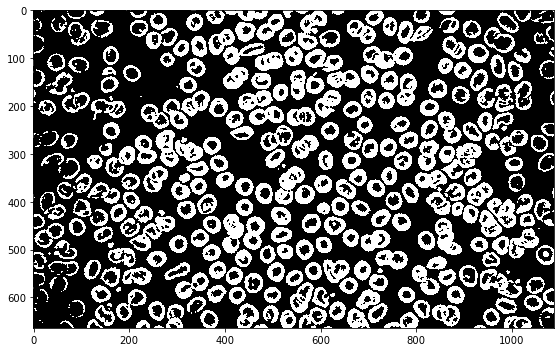

In [17]:
im_cleaned = multi_ero(multi_dil(im_bw,2),1)
plt.figure(figsize=(10,5))
imshow(im_cleaned)

Now we use label to identify individual elements

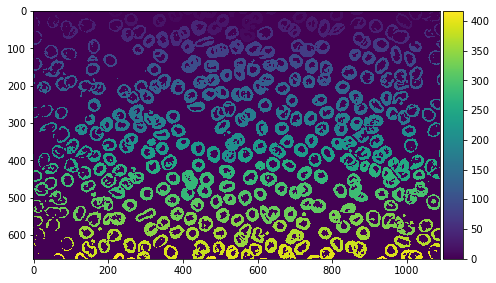

In [18]:
label_im = label(im_cleaned)
props=regionprops(label_im)
plt.figure(figsize=(7,5))
imshow(label_im)

1. Count the number of cells in the photo.
1. Using regionprops, plot a histogram of the cell sizes.
1. Highlight "irregular" cells that are greater than an area treshold:
    - greater than 1.1x of the mean area of the cells
    - greater than 1.5x of the mean area of the cells
    - greater than 1.Nx of the mean area of the cells (play around with N till you get a satisfactory result)
   *(Hint: exploit your knowledge of the RGB color channels to highlight the cells)

Approximation of the number of cells in the photo:  417


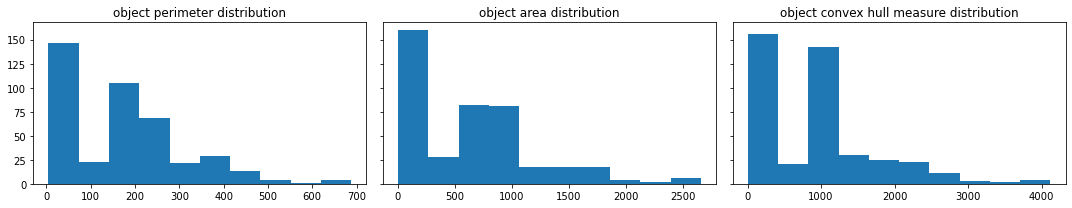

In [19]:
print('Approximation of the number of cells in the photo: ', len(props))

perimeters = [p.perimeter for p in props]
areas = [p.area for p in props]
hull = [p.convex_area for p in props]

f, ax = plt.subplots(1, 3, figsize=(15,3), sharey=True)

ax[0].set_title('object perimeter distribution')
ax[0].hist(perimeters)

ax[1].set_title('object area distribution')
ax[1].hist(areas)

ax[2].set_title('object convex hull measure distribution')
ax[2].hist(hull)

plt.tight_layout()
plt.show()

In [20]:
from numpy import mean
cvx_areas = [p.convex_area for p in props]
mean_area = mean(areas)
mean_cvx_area = mean(cvx_areas)
print('mean area: ', mean_area)
print('mean convex area: ', mean_cvx_area)

mean area:  610.4868105515587
mean convex area:  896.4268585131895


Using `regionprops_table` we are able to get  dictionary of the different select properties of the labeled image.  The dictionary is then easily converted to a pandas dataframe in order to apply some thresholding based on the bounding box area quantiles.

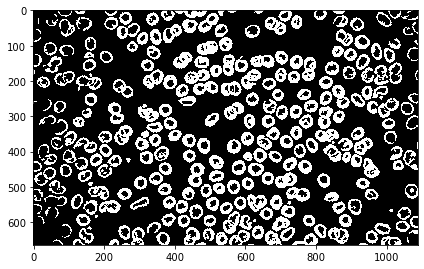

In [44]:
from skimage.measure import regionprops_table
import pandas as pd

props2 = regionprops_table(label_im, properties=['label', 'area',
                                                 'convex_area', 'bbox_area'])
props2 = pd.DataFrame(props2)
props2 = props2[(props2.bbox_area.quantile(0.25) < props2.bbox_area) & 
                (props2.bbox_area < props2.bbox_area.quantile(0.95))]

imshow(np.isin(label_im, props2.label.unique()))

Now that we have thresholded our image, the area property can then be used to highlight certain segments based on our criteria.  For example in this case we highlight segments that are either above or below a certain ratio of the mean segment area.  This allows easier identifiaction and analysis of individual segments.

/opt/conda/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


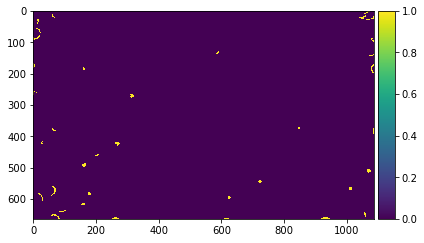

/opt/conda/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


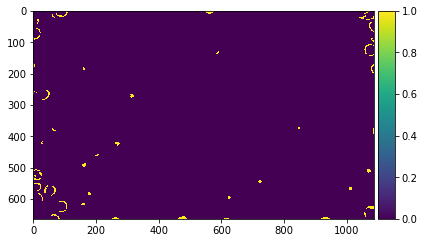

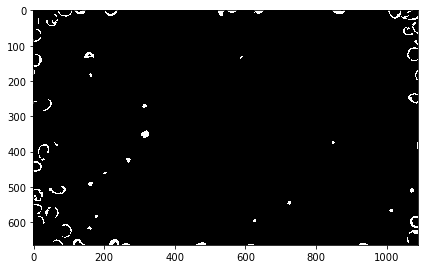

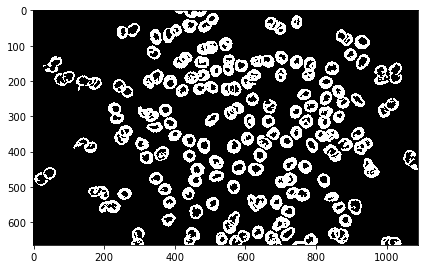

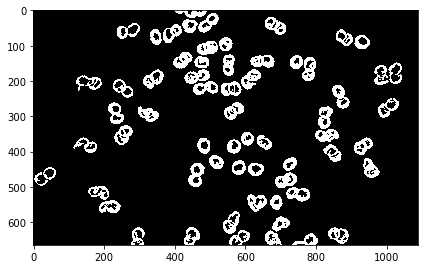

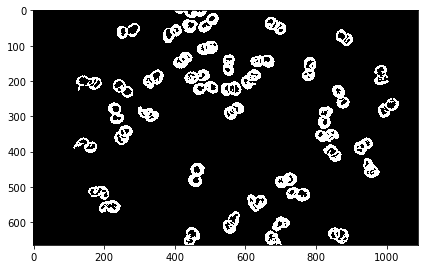

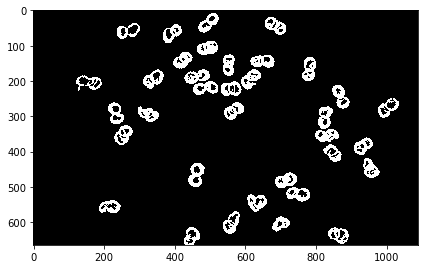

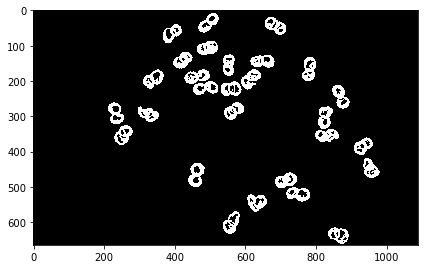

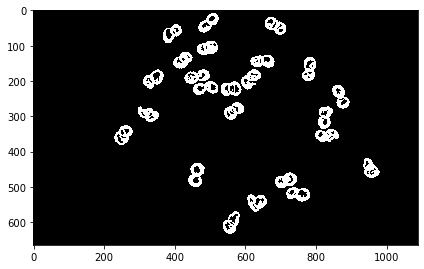

<Figure size 432x288 with 0 Axes>

In [42]:
ratios = [0.2, 0.3, 0.5, 1.1, 1.3, 1.5, 1.7, 1.9, 2.0]
# fig, ax = plt.subplots(3,3, figsize=(15,15))

for ix, ratio in enumerate(ratios):
    if ix < 3:
        temp = props2[props2.area<(props2.area.mean() * ratio)]
    else:
        temp = props2[props2.area>(props2.area.mean() * ratio)]
    
#     ax[ix].imshow(np.isin(label_im, temp.label.unique()))
    imshow(np.isin(label_im, temp.label.unique()))
    plt.show()
        
plt.tight_layout()
plt.show()